# Кластеризация вопросов со Stackoverflow

In [ ]:
%%capture
!pip install bertopic
!pip install -U numpy
!pip install gensim

In [ ]:
import math
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import sklearn.cluster as cluster
import spacy

from bertopic import BERTopic
from gensim import corpora
from gensim.models import LdaModel
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_score
from sklearn.preprocessing import MinMaxScaler
from tqdm.autonotebook import tqdm

In [ ]:
tqdm.pandas()

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words("english"))
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

Загрузка данных:

In [ ]:
sharing_url = "https://drive.google.com/file/d/1zLs02TTxbt1Htk1RdIJM5AaBacs6Y39K/view?usp=sharing"
download_url = "https://drive.google.com/uc?id=" + sharing_url.split("/")[-2]

df = pd.read_csv(download_url)["Question"]
df.head()

,Question
0,I'm trying to automate some features and I nee...
1,I want to get button text value to do the on c...
2,This is my Node codeasync function runClient()...
3,I'm almost finished defining an Inclusion Orde...
4,I am using a depth camera which captures a 500...


## 1. K-means

### a) Векторизация

#### CountVectorizer

In [ ]:
cv = CountVectorizer(lowercase=False, min_df=50)
df_cv = pd.DataFrame(
    cv.fit_transform(df).todense(),
    columns=cv.get_feature_names_out()
)

#### TfIdfVectorizer

$$\text{TF-IDF}(t,d,D) = \text{TF}(t,d) \cdot \text{IDF}(t,D)$$

$$\text{tf}(t, d) = \frac{count(t, d)}{|d|}$$

$$\text{idf}(t, D) = \ln \frac{|D|}{|\{d \in D: t \in d\}|}$$

$count(t, d)$ - количество вхождений термина $t$ в документ $d$

$|d|$ - количество вхождений всех терминов в $d$

$|D|$ - количество документов в датасете $D$

$|\{d \in D: t \in d\}|$ - количество документов в датасете $D$, таких, что в них входит термин $t$ хотя бы один раз

$TF-IDF$ - формула для вычисления "важности" слов в документах.

С одной стороны, важность термина $t$ в документе $d$ пропорциональна $TF$ (term frequency) - доле вхождений термина $t$ в этот документ среди всех терминов: например, чем чаще термин "NLP" встречается в тексте, тем вероятнее, что текст именно про NLP (этот термин важен для текста и определяет его тематику).

С другой стороны, важность термина $t$ в документе $d$ пропорциональна $IDF$ (inverse document frequency): чем больше текстов в датасете, в которых встречается этот термин, тем менее важен этот термин для каждого из документов. Следовательно, у предлогов, артиклей и других стоп-слов будет маленькое значение $IDF$, и их важность окажется низкой.

In [ ]:
tfidf = TfidfVectorizer(lowercase=False, min_df=50)
df_tfidf = pd.DataFrame(
    tfidf.fit_transform(df).todense(),
    columns=tfidf.get_feature_names_out()
)

#### GloVe

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

Код функции ```load_glove``` из https://habr.com/ru/articles/504744/:

In [ ]:
def load_glove(path="glove.6B.100d.txt"):
    embedding_dict = {}
    with open(path, "r") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], "float32")
            embedding_dict[word] = vectors

    return embedding_dict

embeddings_index = load_glove()

Функция ```get_glove_embed``` возвращает эмбеддинг текста как среднее эмбеддингов слов; если в тексте нет ни одного слова, которое есть в словаре GloVe, то возвращается эмбеддинг из нулей:

In [ ]:
def get_glove_embed(
    text,
    tokenize_pattern,
    embeddings_index,
    embedding_dim=100
  ):
    words = tokenize_pattern.findall(text)
    word_vectors = []
    for word in words:
        if word in embeddings_index:
            word_vectors.append(embeddings_index[word])

    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(embedding_dim)

Базовая токенизация регуляркой как у CountVectorizer:

In [ ]:
basic_tokenize_pattern = re.compile(r"(?u)\b\w\w+\b")

glove_embeds = [
    get_glove_embed(item, basic_tokenize_pattern, embeddings_index)
    for item in df
]

In [ ]:
df_glove = pd.DataFrame(glove_embeds, columns=[i for i in range(glove_embeds[0].size)])
df_glove.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.255948,0.217868,0.219710,-0.126842,-0.025422,0.178925,-0.109994,0.003795,0.109836,0.150678,...,-0.043655,0.131014,-0.038653,0.058738,-0.048611,-0.167526,-0.154590,-0.455614,0.453411,0.127340
1,-0.205095,0.219893,0.382684,-0.194373,-0.028725,0.064756,-0.260492,0.104837,0.062672,0.066532,...,-0.265638,0.188667,-0.037376,-0.025437,-0.241213,-0.058452,-0.111022,-0.363882,0.466169,0.054841
2,-0.162441,0.219719,0.335255,-0.195966,-0.063695,0.163074,-0.094722,0.184372,0.067455,0.015365,...,-0.160752,0.165365,-0.090587,-0.034979,-0.173132,-0.127540,0.012522,-0.158558,0.406036,0.025900
3,-0.147023,0.166553,0.349502,-0.110653,0.008998,0.115853,-0.148040,0.186324,0.043910,0.011518,...,-0.149389,0.105023,-0.080409,-0.057826,-0.234365,-0.057806,-0.132629,-0.250473,0.421669,0.071183
4,-0.243797,0.270636,0.348783,-0.008203,-0.002547,0.122787,-0.180508,0.146124,-0.096363,0.133704,...,-0.117214,0.034534,-0.197122,0.089213,-0.188821,-0.112521,-0.292161,-0.453213,0.448597,0.171535


### b) Подбор количества кластеров

In [ ]:
def select_num_clusters(data, min_clusters=2, max_clusters=20):
    sns.set(rc={"figure.figsize": (15, 4)})

    # Вычисление инерции и silhouette score для разного числа кластеров
    inertia = []
    silhouette = []

    for i in tqdm(range(min_clusters, max_clusters + 1)):

        kmeans = cluster.KMeans(
            n_clusters=i,
            init="k-means++",
            n_init=15,
            max_iter=500,
            random_state=17
        )

        kmeans.fit(data)

        inertia.append(kmeans.inertia_)
        silhouette.append(
            silhouette_score(
                data,
                kmeans.labels_,
                metric="euclidean"
            )
        )

    # График для инерции
    plt.subplot(1, 2, 1)
    plt.plot(range(2, len(inertia) + 2), inertia, marker="x", color="blue")
    plt.xticks(range(2, len(inertia) + 2))
    plt.xlabel("Number of clusters")
    plt.title("K-means Inertia", fontweight="bold")
    plt.grid(True)

    # График для silhouette score
    plt.subplot(1, 2, 2)
    plt.bar(range(2, len(silhouette) + 2), silhouette, color="blue")
    plt.xticks(range(2, len(silhouette) + 2))
    plt.xlabel("Number of clusters")
    plt.title("Silhouette Score", fontweight="bold")
    plt.grid(True)

    plt.show()

#### CountVectorizer

  0%|          | 0/19 [00:00<?, ?it/s]

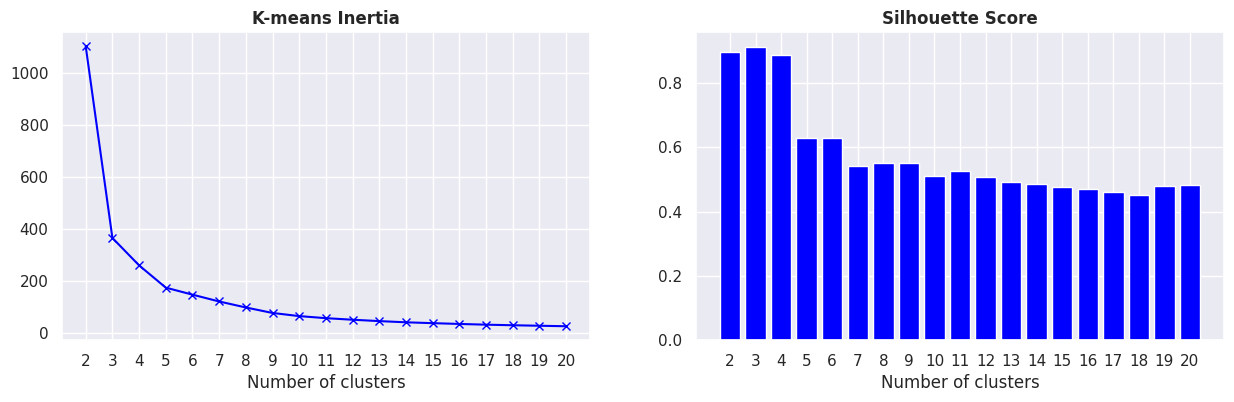

In [ ]:
sc = MinMaxScaler()
pca_2 = PCA(2)

pca_2_cv = pca_2.fit_transform(sc.fit_transform(df_cv))
select_num_clusters(pca_2_cv)

Оптимальное количество кластеров - 3

#### TfIdfVectorizer

  0%|          | 0/19 [00:00<?, ?it/s]

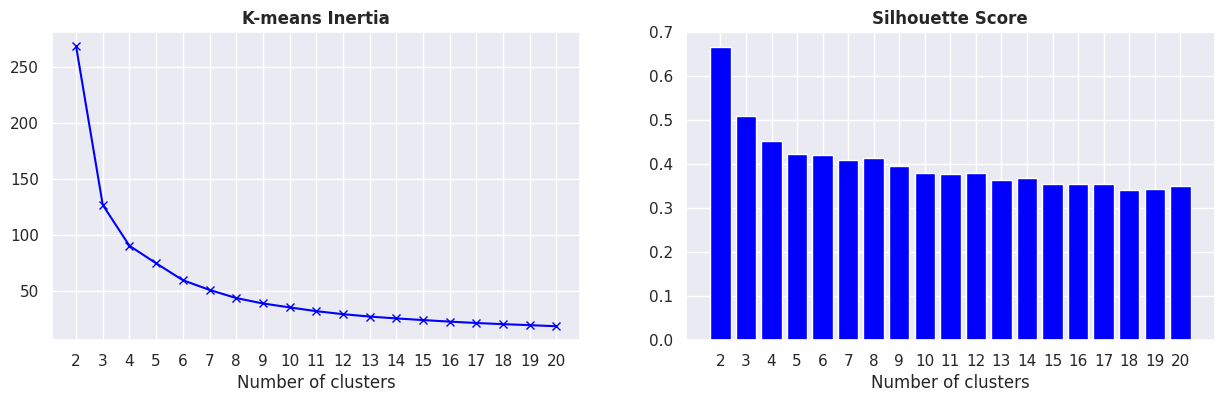

In [ ]:
pca_2 = PCA(2)

pca_2_tfidf = pca_2.fit_transform(df_tfidf)
select_num_clusters(pca_2_tfidf)

Оптимальное количество кластеров - 3

#### GloVe

  0%|          | 0/19 [00:00<?, ?it/s]

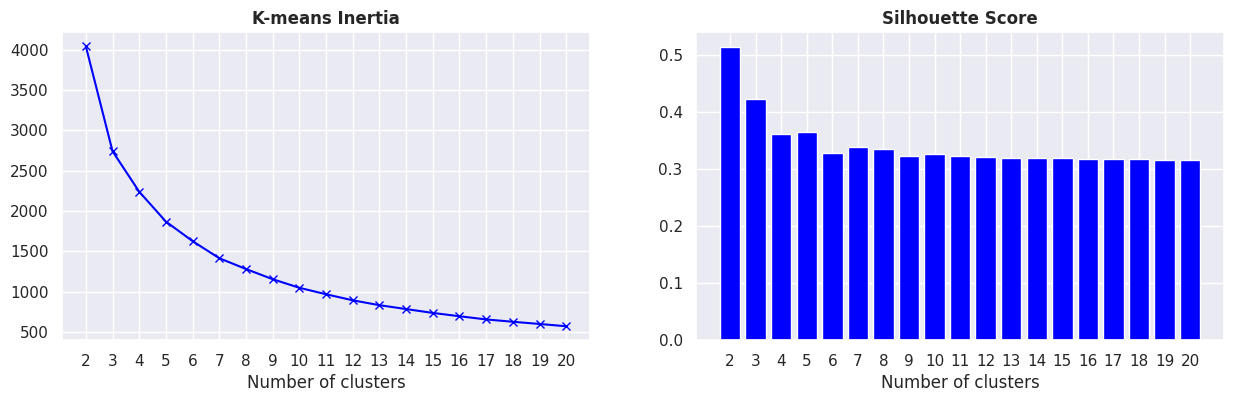

In [ ]:
pca_2 = PCA(2)

pca_2_glove = pca_2.fit_transform(df_glove)
select_num_clusters(pca_2_glove)

Оптимальное количество кластеров - 3

### c) Кластеризация + d) Ближайшие к центроидам тексты

In [ ]:
def cluster_with_kmeans(num_clusters, data):
    kmeans = cluster.KMeans(
        n_clusters=num_clusters,
        init="k-means++",
        n_init=15,
        max_iter=500,
        random_state=17
    )

    kmeans_labels = kmeans.fit_predict(data)
    centroids = kmeans.cluster_centers_
    closest, _ = pairwise_distances_argmin_min(centroids, data)

    return kmeans_labels, centroids, closest

In [ ]:
def vis_clusters(data, labels, centroids=None):
    sns.set(rc={"figure.figsize": (6, 5)})

    plt.title("Clustered Data (PCA visualization)", fontweight="bold")

    scatter = plt.scatter(
        x=data[:, 0], y=data[:, 1],
        c=labels, cmap="viridis"
    )

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")

    if centroids is not None:
        plt.scatter(
            centroids[:, 0], centroids[:, 1],
            marker="x", s=160, color="black"
        )

        legend_labels = [f"Cluster {i + 1}" for i in range(len(centroids))]
        plt.legend(
            handles=scatter.legend_elements()[0],
            labels=legend_labels,
            title="Clusters"
        )

    plt.show()

In [ ]:
def print_closest(orig_data, closest):
    for i, idx in enumerate(closest):
        print(f"Cluster {i + 1}:\n{orig_data[idx]}\n")

#### CountVectorizer

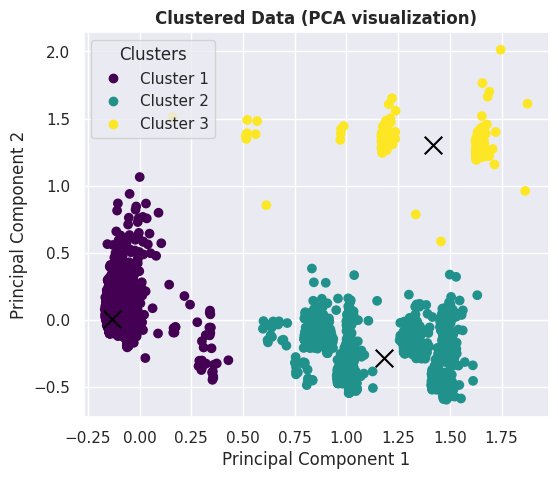

In [ ]:
kmeans_labels, centroids, closest = cluster_with_kmeans(3, pca_2_cv)
vis_clusters(pca_2_cv, kmeans_labels, centroids)

In [ ]:
print_closest(df, closest)

Cluster 1:
The question is simple as that - is it possible to set dynamically/programmatically a validator for the javax.validation.@Constraint, based on, lets say a flag, from the properties in a Spring Boot application?My attempt was to declare a custom Validator as interface, which extends ConstraintValidator, and then have 2 specific classes implementing it, each with its own validation method. The type to be validated is the same. But it wouldn't allow me to do that for the interface, nor abstract classes - looks like @Constraint accepts only classes that can be instantiated right away.Nor I found any example for such approach.Any idea if it's even possible?

Cluster 2:
Closed. This question is opinion-based. It is not currently accepting answers.Want to improve this question? Update the question so it can be answered with facts and citations by editing this post.Closed yesterday.Improve this questionAm using Azure Data Factory and want to check, if all coding guidelines and namin

Кластер 1: динамическая валидация в Spring Boot

Кластер 2: инструменты для проверки кода в Azure Data Factory

Кластер 3: ошибки конфигурации при развертывании Django-приложений

Потенциальные темы для кластеров: бэкенд, data engineering, DevOps

#### TfIdfVectorizer

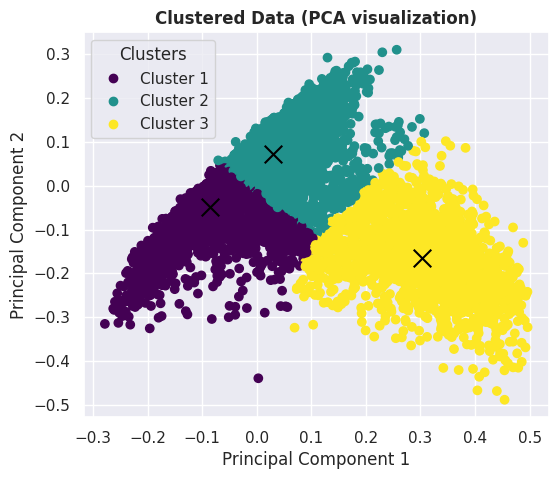

In [ ]:
kmeans_labels, centroids, closest = cluster_with_kmeans(3, pca_2_tfidf)
vis_clusters(pca_2_tfidf, kmeans_labels, centroids)

In [ ]:
print_closest(df, closest)

Cluster 1:
I am getting images from my phone gallery using React Native Image Picker Library, the images are in base64 format, when I try to upload them to firebase storage, they do not display, I have tried various solutions but none of them work here they are :const response = await fetch(result.assets[0].uri)const blob = response.blob()uploadBytes(imgRef, blob).then((snapshot)=>{    getDownloadURL(ref(storage, result.assets[0].fileName))    .then((url) => {        url_ = url;        userDetails.update_details("image_1", url_);    })})This one stores an octet streamconst binaryData = Buffer.from(result.assets[0].base64, "base64");const blob = new Blob([binaryData], { type: 'image/png' });uploadBytes(imgRef, blob).then((snapshot)=>{    getDownloadURL(ref(storage, result.assets[0].fileName))    .then((url) => {        url_ = url;        userDetails.update_details("image_1", url_);    })})This saves the image as png but it does not open on firebase console.

Cluster 2:
I'm trying to imp

Кластер 1: загрузка изображений в Firebase Storage из React Native

Кластер 2: управление SSL-сертификатами в Azure Web Apps

Кластер 3: ошибка JOIN в SQL-запросе

Потенциальные темы для кластеров: фронтенд, DevOps, data engineering

#### GloVe

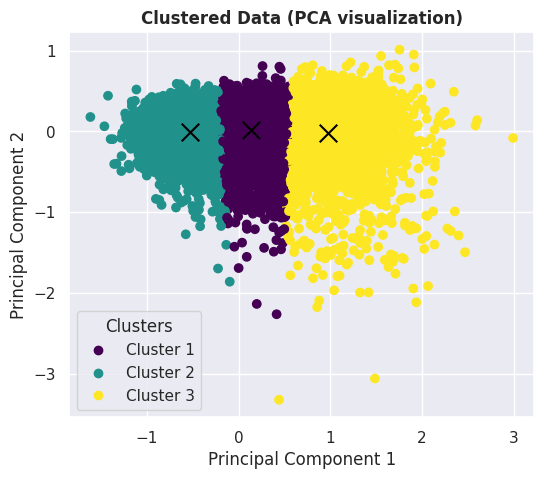

In [ ]:
kmeans_labels, centroids, closest = cluster_with_kmeans(3, pca_2_glove)
vis_clusters(pca_2_glove, kmeans_labels, centroids)

In [ ]:
print_closest(df, closest)

Cluster 1:
The error is -npm ERR! code ERESOLVEnpm ERR! ERESOLVE unable to resolve dependency treenpm ERR!npm ERR! While resolving: cab_management_ui@0.1.0npm ERR! Found: react@18.2.0npm ERR! node_modules/reactnpm ERR!   react@"^18.2.0" from the root projectnpm ERR!npm ERR! Could not resolve dependency:npm ERR! peer react@"^16.8.0 || ^17.0.0" from @material-ui/core@4.12.4npm ERR! node_modules/@material-ui/corenpm ERR!   peer @material-ui/core@"^4.0.0" from @material-ui/icons@4.11.3npm ERR!   node_modules/@material-ui/iconsnpm ERR!     @material-ui/icons@"^4.11.3" from the root projectnpm ERR!npm ERR! Fix the upstream dependency conflict, or retrynpm ERR! this command with --force or --legacy-peer-depsnpm ERR! to accept an incorrect (and potentially broken) dependency resolution.Also, while doing so, it is not creating the node_modules/ directory. I am not able to understand the issue here and idk how to fix this. If anyone know how to, pls help.

Cluster 2:
I am trying to make an MSIX 

Кластер 1: проблемы с зависимостями в Node.js

Кластер 2: сборка и упаковка приложений в Windows

Кластер 3: ошибки в Android-эмуляторе

Потенциальные темы для кластеров: фронтенд, cистемная разработка, мобильная разработка

### e) Предобработка

In [ ]:
def preprocess(doc):
    # токенизация, удаление стоп-слов и пунктуации, лемматизация
    lemmata = [
        token.lemma_ for token in doc
        if (
            token.lemma_.isalpha()
            and token.lemma_ not in stop_words
        )
    ]

    # приведение к нижнему регистру
    return " ".join(lemmata).lower()

In [ ]:
preprocess(nlp("I wanted to create an image, but it didn't work."))

'i want create image work'

In [ ]:
# удаление ссылок
cleaned_texts = [re.sub(r"http\S+", "", text) for text in df]

# остальная предобработка
preprocessed_texts = []
for doc in tqdm(nlp.pipe(cleaned_texts), total=len(cleaned_texts)):
    preprocessed_texts.append(preprocess(doc))

  0%|          | 0/22123 [00:00<?, ?it/s]

In [ ]:
df_preprocessed = pd.Series(preprocessed_texts)
df_preprocessed.head()

,0
0,i try automate feature i need scarp web page i...
1,i want get button text value click command i f...
2,node codeasync function runclient hello world ...
3,i almost finish define inclusion order cubical...
4,i use depth camera capture depth map meter i a...


## 1. K-means

### a) Векторизация

#### CountVectorizer

In [ ]:
cv = CountVectorizer(lowercase=False, min_df=50)
df_cv = pd.DataFrame(
    cv.fit_transform(df_preprocessed).todense(),
    columns=cv.get_feature_names_out()
)

#### TfIdfVectorizer

In [ ]:
tfidf = TfidfVectorizer(lowercase=False, min_df=50)
df_tfidf = pd.DataFrame(
    tfidf.fit_transform(df_preprocessed).todense(),
    columns=tfidf.get_feature_names_out()
)

#### GloVe

In [ ]:
glove_embeds = [
    get_glove_embed(item, basic_tokenize_pattern, embeddings_index)
    for item in df_preprocessed
]

In [ ]:
df_glove = pd.DataFrame(glove_embeds, columns=[i for i in range(glove_embeds[0].size)])
df_glove.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.348323,0.226464,0.258870,-0.072043,0.000701,0.095811,-0.171349,-0.069928,0.119118,0.130847,...,0.032401,0.221719,0.020916,-0.079455,-0.060847,-0.170963,-0.147998,-0.362920,0.512517,0.177190
1,-0.208028,0.236728,0.332875,-0.224144,0.029436,0.200892,-0.258290,-0.006949,0.115729,0.026403,...,-0.226777,0.221755,-0.017099,0.008265,-0.124601,-0.082076,-0.098334,-0.444456,0.360243,0.172726
2,-0.134164,0.252147,0.251921,-0.124789,-0.146547,0.170373,-0.032736,0.140233,0.114461,0.011485,...,-0.139010,0.274218,-0.015289,-0.135963,0.023362,-0.096875,0.109238,-0.126080,0.236574,0.031164
3,-0.105311,0.276718,0.163230,0.089250,-0.198008,0.020996,0.041078,0.101712,-0.061836,0.130471,...,-0.264444,0.108410,-0.061839,-0.144865,-0.055508,-0.065423,-0.026270,-0.352007,0.389717,-0.048238
4,-0.385130,0.353084,0.212312,0.119933,-0.097642,0.064532,-0.169682,-0.024887,0.016213,0.233147,...,-0.086415,0.137803,-0.147687,-0.195466,-0.033576,-0.170325,-0.215113,-0.469022,0.355709,0.179791


### b) Подбор количества кластеров

#### CountVectorizer

  0%|          | 0/19 [00:00<?, ?it/s]

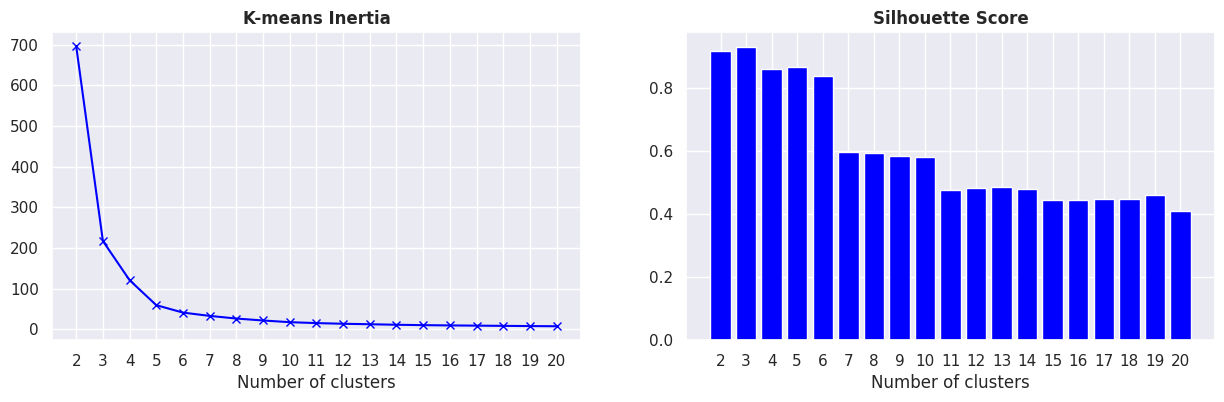

In [ ]:
sc = MinMaxScaler()
pca_2 = PCA(2)

pca_2_cv = pca_2.fit_transform(sc.fit_transform(df_cv))
select_num_clusters(pca_2_cv)

Оптимальное количество кластеров - 3



#### TfIdfVectorizer

  0%|          | 0/19 [00:00<?, ?it/s]

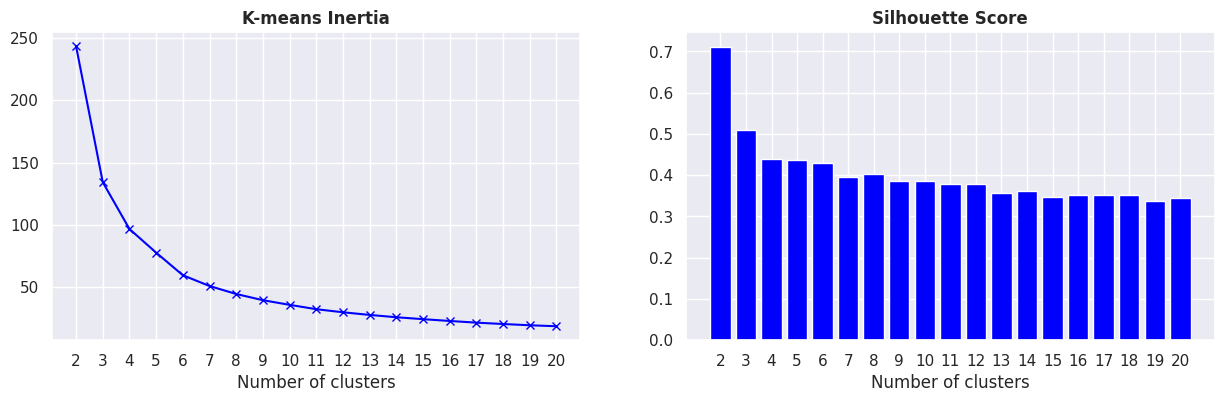

In [ ]:
pca_2 = PCA(2)

pca_2_tfidf = pca_2.fit_transform(df_tfidf)
select_num_clusters(pca_2_tfidf)

Оптимальное количество кластеров - 3

#### GloVe

  0%|          | 0/19 [00:00<?, ?it/s]

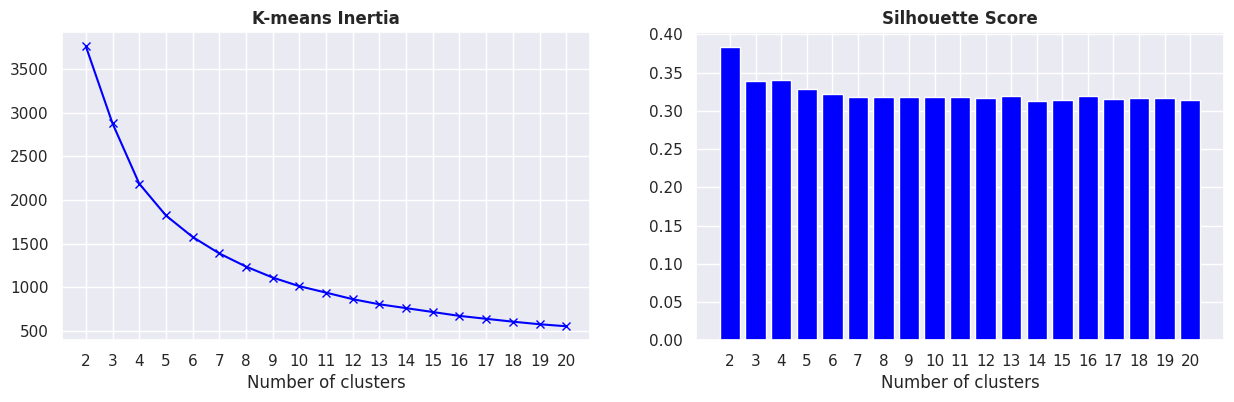

In [ ]:
pca_2 = PCA(2)

pca_2_glove = pca_2.fit_transform(df_glove)
select_num_clusters(pca_2_glove)

Оптимальное количество кластеров - 3 или 4

### c) Кластеризация + d) Ближайшие к центроидам тексты

#### CountVectorizer

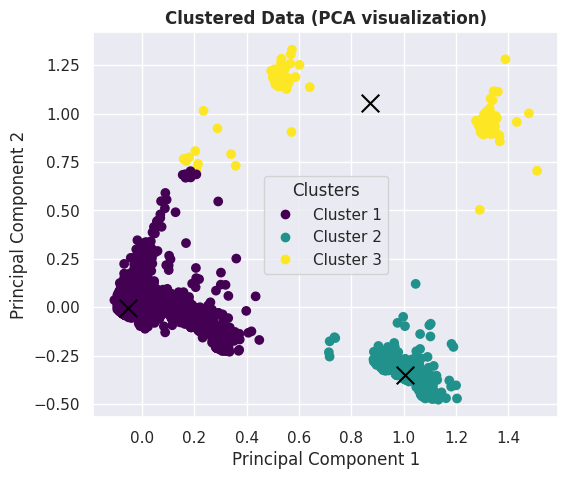

In [ ]:
kmeans_labels, centroids, closest = cluster_with_kmeans(3, pca_2_cv)
vis_clusters(pca_2_cv, kmeans_labels, centroids)

In [ ]:
print_closest(df, closest)

Cluster 1:
This question already has answers here:NullReferenceException when dragging control onto Form (2 answers)Closed 2 days ago.I created a Window Form project on Visual Studio 2022, based on .net 6.0. But when I pull the control into the Form, Visual Studio prompts:"No object reference set to an instance of an object"In addition, I am using an external monitor, and I did this on the monitor, but I didn't have this problem when I did it on another monitor. Why?

Cluster 2:
Closed. This question needs to be more focused. It is not currently accepting answers.Want to improve this question? Update the question so it focuses on one problem only by editing this post.Closed 8 days ago.Improve this questionI want to scrape data from https://pdfdrive.com & https://sci-hub-links.com/pdfdrive/ their robots.txt disallow almost everything but the main page and i was just wondering if there was a way to get around with without using selenium?this is what i tried:import requestsfrom bs4 import

Кластер 1: разработка в Visual Studio

Кластер 2: веб-скрапинг и обход ограничений

Кластер 3: обучение QLoRA-адаптера для модели

Потенциальные темы для кластеров: разработка, веб-скрапинг, ML

#### TfIdfVectorizer

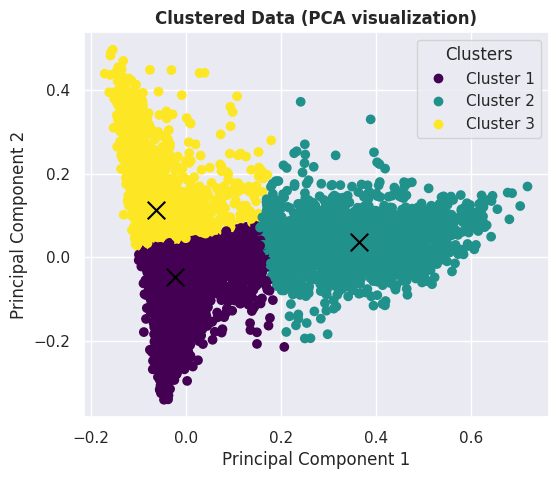

In [ ]:
kmeans_labels, centroids, closest = cluster_with_kmeans(3, pca_2_tfidf)
vis_clusters(pca_2_tfidf, kmeans_labels, centroids)

In [ ]:
print_closest(df, closest)

Cluster 1:
I have a system in C# and I need to receive notifications via Firebase Cloud Messaging (FCM), because my client side is in C#. It is possible to receive these notifications?I looked at the documentation regarding Firebase Cloud Messaging but I didn't find official support for client-side C#

Cluster 2:
Closed. This question needs details or clarity. It is not currently accepting answers.Want to improve this question? Add details and clarify the problem by editing this post.Closed 2 days ago.Improve this questionThis request is missing a valid app identifier, meaning that Play Integrity checks, and reCAPTCHA checks were unsuccessful. Failed to get reCAPTCHA token with error [There was an internal error in the web widget. [ {"code": "auth/internal-error", "message":"(\ "error\': (\"code\': 403, \"message\":\"Requests from this Android client application <empty> are blocked. \", \"errors\": [f\ "message\": \"Requests from this Android client application <empty> are blocked. \",

Кластер 1: генерация PDF на стороне клиента

Кластер 2:  динамическая обработка изображений

Кластер 3: ошибки аутентификации в Firebase

Потенциальные темы для кластеров: фронтенд, бэкенд, мобильная разработка

#### GloVe

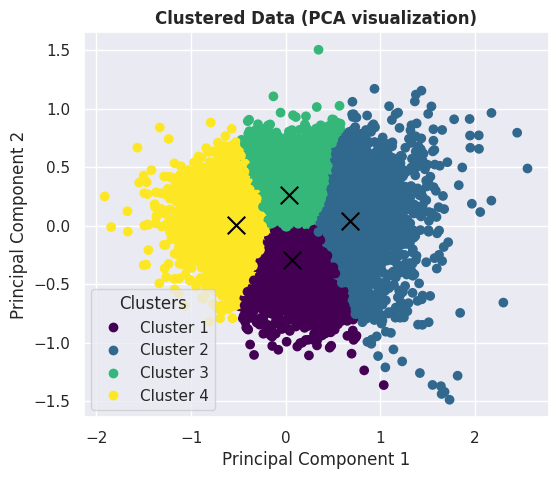

In [ ]:
kmeans_labels, centroids, closest = cluster_with_kmeans(4, pca_2_glove)
vis_clusters(pca_2_glove, kmeans_labels, centroids)

In [ ]:
print_closest(df, closest)

Cluster 1:
I have written a batch file for some git commands, here is the code@echo offsetlocalset /p branch_name=Enter the branch name: rem Checkout a different branchgit checkout branch2rem Delete the asked branchgit branch -D %branch_name%git fetchrem Checkout the asked branch againgit checkout %branch_name%endlocalnow after git fetch it asks for the passphrase for ssh key , that i want to fill automatically from the batch filei tried with echo like thisecho passphrase | git fetchbut it did not workany help on this?And one more thing if on start it can ask do you want to use current branch then y/N. if y then no need to ask enter branch name otherwise ask the branch name to use?

Cluster 2:
This question already has answers here:scanf() leaves the newline character in the buffer (7 answers)Closed 4 days ago.#include <stdio.h>#include <stdlib.h>typedef struct Details{    int num;    char message[100];}Notes;void write(FILE*,Notes);void read(FILE*);int main(){    int c;    FILE *fp = 

Кластер 1: автоматизация Git-команд

Кластер 2: ошибка с вводом пользователя в коде на C

Кластер 3: слои в Keras

Кластер 4: переменные в Ansible

Потенциальные темы для кластеров: системные скрипты, низкоуровневые языки, ML, DevOps

### f) Сравнение

После предобработки:

Для CountVectorizer коэффициент Силуэтта остался на прежнем уровне, а инерция уменьшилась => кластеризация стала лучше

Для TfIdfVectorizer коэффициент Силуэтта незначительно увеличился, инерция осталась прежней => кластеризация стала лучше

Для GloVe поменялось оптимальное количество кластеров, т.к. коэффициент Силуэтта для 4 кластеров стал выше, чем для 3. При этом он стал меньше и для 3, и для 4 кластеров по сравнению со скорами до предобработки. Инерция улучшилась для 3 кластеров, но уменьшилась для 4. В итоге мы имеем с одной стороны незначительное уменьшение коэффициента Силуэтта (ухудшение кластеризации) и с другой стороны незначительное уменьшение инерции (улучшение кластеризации). Такой результат логичен, т.к. эмбеддинги более устойчивы к отсутствию предобработки, чем bag-of-words и tf-idf.

## 2. DBSCAN

### a) Кластеризация на предобработанных данных

In [ ]:
def cluster_with_dbscan(data, eps=0.5):
    dbscan = cluster.DBSCAN(min_samples=2, eps=eps)
    dbscan_labels = dbscan.fit_predict(data)

    print(
        "Коэффициент Силуэтта:",
        silhouette_score(
            data,
            dbscan.labels_,
            metric="euclidean"
        )
    )

    return dbscan_labels

#### CountVectorizer

Коэффициент Силуэтта: 0.9329290551866589


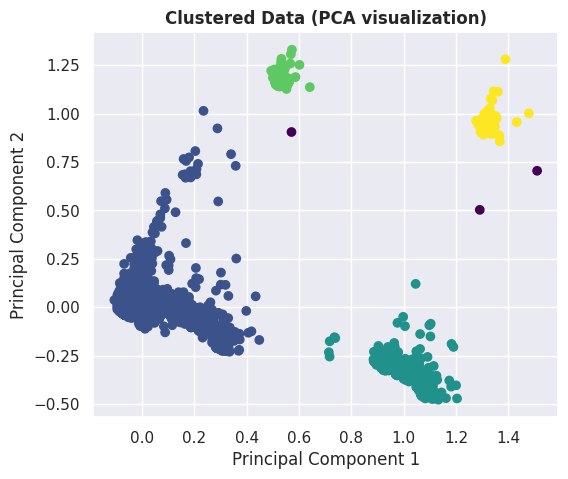

In [ ]:
dbscan_labels = cluster_with_dbscan(pca_2_cv, eps=0.2)
vis_clusters(pca_2_cv, dbscan_labels)

#### TfIdfVectorizer


Коэффициент Силуэтта: -0.3795374548974104


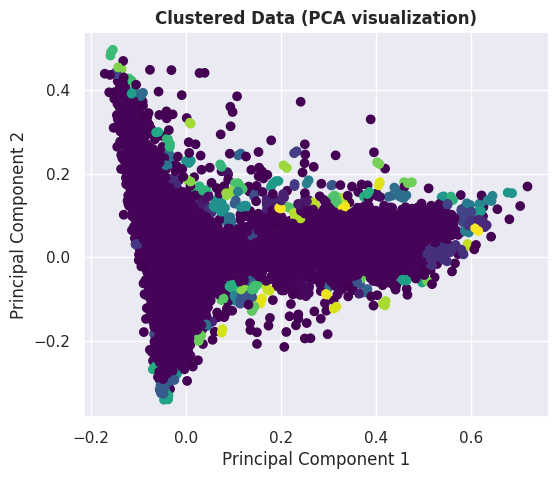

In [ ]:
dbscan_labels = cluster_with_dbscan(pca_2_tfidf, eps=0.01)
vis_clusters(pca_2_tfidf, dbscan_labels)

#### GloVe

Коэффициент Силуэтта: -0.4037925


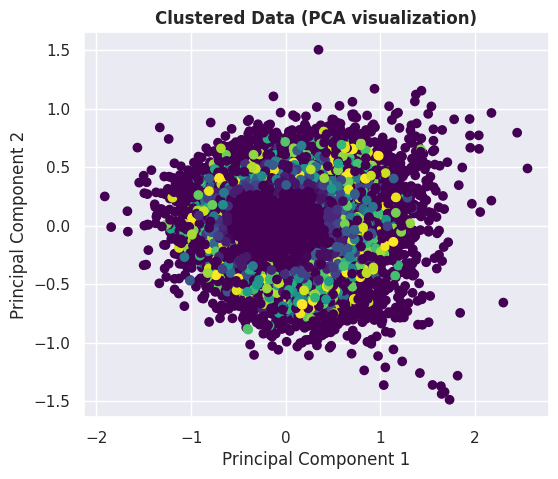

In [ ]:
dbscan_labels = cluster_with_dbscan(pca_2_glove, eps=0.01)
vis_clusters(pca_2_glove, dbscan_labels)

### b) Сравнение

Для CountVectorizer кластеризация с DBSCAN лучше по качеству, чем с K-Means: коэффициент Силуэтта тоже >0.9, выделяются очевидные из визуализации четыре кластера, выбросы игнорируются. Если задать для K-Means 4 кластера, то результат будет следующим, что неоптимально (второй кластер можно было бы разделить на два):

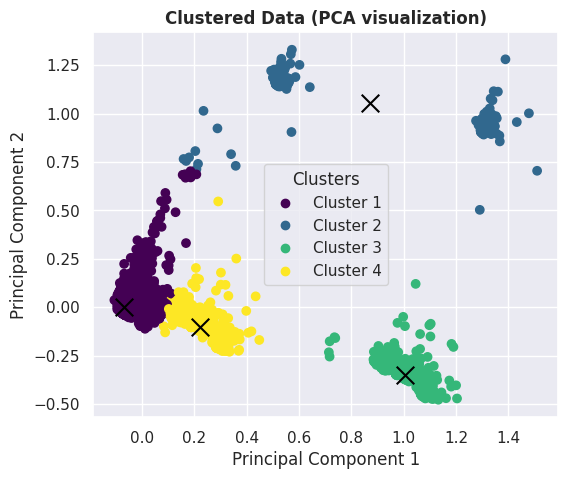

In [ ]:
kmeans_labels, centroids, closest = cluster_with_kmeans(4, pca_2_cv)
vis_clusters(pca_2_cv, kmeans_labels, centroids)

Для TF-IDF и GloVe кластеризация через DBSCAN неоптимальна, т.к. кластеры находятся друг от друга на очень маленьком расстоянии как одна общая масса данных, а это defeats the purpose of DBSCAN.

## 3. Sentence Transformers

In [ ]:
def get_batch(dataset, batch_size=1):
    for batch_start_idx in range(0, len(dataset), batch_size):
        yield dataset[batch_start_idx : min(batch_start_idx + batch_size, len(dataset))]

In [ ]:
def get_sbert_embeds(
    dataset, model, batch_size=1
  ):
    sbert_embeds = []
    for batch in tqdm(
        get_batch(dataset, batch_size=batch_size),
        total=int(math.ceil(len(dataset) / batch_size))
    ):
        sbert_embeds.extend(model.encode(batch))
    return sbert_embeds

In [ ]:
model = SentenceTransformer("prdev/mini-gte")

In [ ]:
sbert_embeds = get_sbert_embeds(list(df), model, batch_size=4)

  0%|          | 0/5531 [00:00<?, ?it/s]

In [ ]:
df_sbert = pd.DataFrame(sbert_embeds, columns=[i for i in range(sbert_embeds[0].size)])
df_sbert.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.588832,-0.741453,-0.097096,-0.091845,0.066032,-0.268339,0.049614,-0.646589,1.442242,0.064768,...,0.363481,-0.115762,-0.331196,-0.197838,-0.351480,0.702592,-0.203173,0.120793,-0.359282,-0.071839
1,0.304356,0.239586,-0.368119,-0.514892,-0.167708,0.366124,0.343202,-0.870618,0.603465,-0.188608,...,0.004923,-0.222787,-0.759335,-0.991035,-0.087655,-0.611496,0.136621,0.040364,0.209082,0.138853
2,-0.099793,0.004312,0.485965,0.389778,0.901455,-0.131657,0.611365,0.388499,-0.275438,0.372834,...,-0.469215,0.464881,-0.180182,-0.478228,-0.700775,-0.077485,-0.379020,-0.381325,0.133239,-0.521613
3,0.859694,-0.364187,-0.251823,-0.491494,-0.157617,-0.112949,-0.285133,-0.167329,-0.688729,-0.775224,...,-0.705193,-0.189520,-0.462270,-0.586467,-0.077151,0.030033,0.874620,-1.083513,-1.013773,-0.576884
4,0.338578,-0.673557,0.922756,-0.445029,0.569902,-0.902455,0.434712,-0.531783,0.123732,-0.421944,...,-0.002663,0.541142,-0.738405,-0.713381,-0.005506,0.145097,-0.975920,-0.825285,-0.368626,-0.010526


  0%|          | 0/19 [00:00<?, ?it/s]

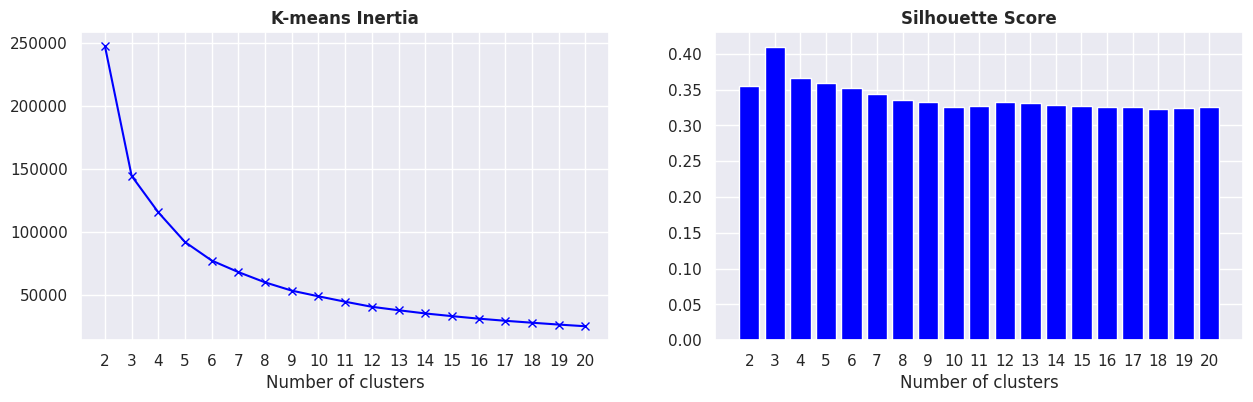

In [ ]:
pca_2 = PCA(2)

pca_2_sbert = pca_2.fit_transform(df_sbert)
select_num_clusters(pca_2_sbert)

Оптимальное количество кластеров - 3. Коэффициент Силуэтта ~0.4 (лучше, чем у GloVe с предобработкой, но хуже, чем у GloVe без предобработки).

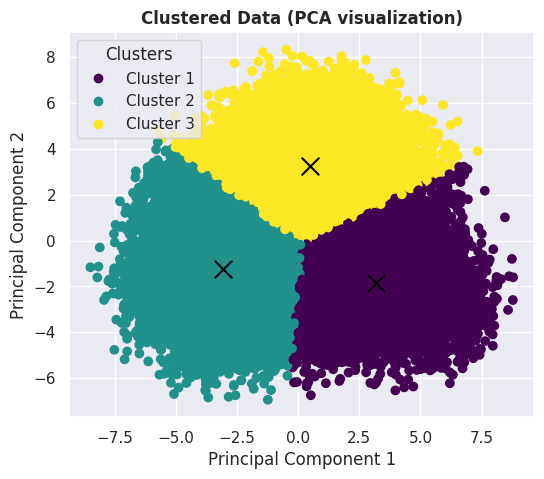

In [ ]:
kmeans_labels, centroids, closest = cluster_with_kmeans(3, pca_2_sbert)
vis_clusters(pca_2_sbert, kmeans_labels, centroids)

In [ ]:
print_closest(df, closest)

Cluster 1:
I'm new to Streamlit and trying to plot a graph with the widget st.line_chart.I have a dictionary that I filled with data from different files with :listFilesTemp = glob.glob(folder+ '/*.npy')nbFilesTemp = len(listFilesTemp)    TempDict = {}for j in range(len(listFilesTemp)):           dataExtract = np.load(listFilesTemp[j])     filename = listFilesTemp[j].replace(folderTemp + '\\', '')           TempDict[filename] = dataExtract    So I now have a dictionary composed of string keys and for each an array of values.I would like to plot data from several files on 1 interactive graph, but I must be missing something from the documentation, I don't manage to succeed. I tried :for i in TempDict:        st.line_chart(data=TempDict[i], x=None, y=None)But it displays 1 graph/file. It seems that I have to modify the x or y parameters of this function, I tried a couple of things but I have not managed to do so far. How can I say to streamlit to plot several arrays from my dict in one g

## 4. BERTopic

BERTopic выделил 215 тем:

In [ ]:
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(df)
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,9859,-1_the_to_is_and,"[the, to, is, and, in, of, it, that, for, this]",[I'm trying to scrape a website that doesn't u...
1,0,1179,0_question_software_accepting_closed,"[question, software, accepting, closed, agoimp...",[Closed. This question is not about programmin...
2,1,350,1_token_authentication_user_cancellationtoken,"[token, authentication, user, cancellationtoke...",[I need to get the access token from oauth2.0 ...
3,2,336,2_na_dataframe_2l_nan,"[na, dataframe, 2l, nan, 0l, 1l, column, acaci...",[I am trying to get R (tidyverse) to check the...
4,3,332,3_const_component_div_useeffect,"[const, component, div, useeffect, usestate, s...",[Just want to preface this by saying I know th...
...,...,...,...,...,...
219,218,10,218_cloudwatch_alarms_graylog_metrics,"[cloudwatch, alarms, graylog, metrics, disk, s...",[Hi all is there any way where i can get url p...
220,219,10,219_tab_tabs_wxidany_wxbitmaptypeany,"[tab, tabs, wxidany, wxbitmaptypeany, tabbedpa...",[Is it possible to disallow minimize pane smal...
221,220,10,220_rooms_calendar_blah_faxrecord,"[rooms, calendar, blah, faxrecord, datecreated...",[I am trying to accomplish what I believed to ...
222,221,10,221_ship_itinerary_basehandler_class,"[ship, itinerary, basehandler, class, mammal, ...",[Is there a way to do that without using a sub...


In [ ]:
topic_model.visualize_topics()

Topic 0: generic слова о StackOverflow в целом

In [ ]:
topic_model.get_topic(0)

[('question', 0.021552705559926933),
 ('software', 0.017473925854170954),
 ('accepting', 0.013861966730868374),
 ('closed', 0.013579798658622685),
 ('agoimprove', 0.012043488234069871),
 ('currently', 0.01190468384897599),
 ('programming', 0.011418428609996116),
 ('days', 0.010853358541075848),
 ('tools', 0.010110870788593077),
 ('this', 0.009880778188229775)]

Topic 3: фронтенд

In [ ]:
topic_model.get_topic(3)

[('const', 0.016018383355540622),
 ('component', 0.012784025860599865),
 ('div', 0.012383170486483321),
 ('useeffect', 0.009884494732706669),
 ('usestate', 0.00956604258125876),
 ('state', 0.009186299236166618),
 ('react', 0.007675605750724999),
 ('button', 0.007535556725467433),
 ('value', 0.007302728024651669),
 ('return', 0.006993275876438277)]

Topic 4: Python

In [ ]:
topic_model.get_topic(4)

[('line', 0.021048543517245794),
 ('module', 0.019012652439571565),
 ('file', 0.018155872353407466),
 ('python', 0.016170833681251374),
 ('install', 0.016141768074731524),
 ('import', 0.014980330846607225),
 ('pip', 0.014894881110360077),
 ('package', 0.011098068227737798),
 ('installed', 0.00933539776269793),
 ('conda', 0.008947874382323289)]

Topic 11: криптография

In [ ]:
topic_model.get_topic(11)

[('certificate', 0.02937894283039647),
 ('ssl', 0.01508375224457488),
 ('key', 0.014488579437165363),
 ('nginx', 0.010164566669848095),
 ('server', 0.00943538945787923),
 ('https', 0.00853698462158179),
 ('certificates', 0.006890818474214685),
 ('proxysetheader', 0.006879869550014883),
 ('domain', 0.006801574193690652),
 ('iv', 0.006733862305477325)]

Topic 13: ML

In [ ]:
topic_model.get_topic(13)

[('model', 0.02139605308883038),
 ('loss', 0.019239399941567148),
 ('training', 0.014675344061277067),
 ('tindices', 0.0110654794414216),
 ('tparams', 0.0110654794414216),
 ('train', 0.009540947217132504),
 ('shape', 0.008600675932385806),
 ('devicecpu', 0.00836471987367438),
 ('layer', 0.008346885371577357),
 ('tensorflow', 0.008209285802108364)]

## 5. LDA Topic Modeling

In [ ]:
tokenized_texts = [
    basic_tokenize_pattern.findall(text)
    for text in df_preprocessed
]

dictionary = corpora.Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

lda_model = LdaModel(
    corpus,
    num_topics=3,
    id2word=dictionary,
    passes=15
)

for idx, topic in lda_model.print_topics(-1):
    print(f"Тема {idx + 1}: {topic}")

Тема 1: 0.020*"const" + 0.017*"question" + 0.011*"close" + 0.011*"div" + 0.010*"answer" + 0.008*"improve" + 0.008*"text" + 0.008*"page" + 0.007*"button" + 0.007*"image"
Тема 2: 0.015*"file" + 0.015*"use" + 0.015*"error" + 0.010*"try" + 0.009*"get" + 0.009*"run" + 0.007*"app" + 0.007*"work" + 0.006*"code" + 0.006*"user"
Тема 3: 0.013*"return" + 0.012*"use" + 0.012*"string" + 0.009*"get" + 0.009*"value" + 0.009*"public" + 0.008*"datum" + 0.008*"code" + 0.008*"new" + 0.008*"try"
